In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier
from catboost import FeaturesData
from catboost import Pool, cv

%matplotlib inline

# Load Data

In [2]:
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')
print('Train:\t', train.shape)
print('Test: \t', test.shape)

Train:	 (307506, 172)
Test: 	 (48744, 171)


In [3]:
# define categorical features
cat_feature = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
               'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
               'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
               'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 
               'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 
               'Binary_CREDIT_DAY_OVERDUE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 
               'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 
               'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',  
               'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
               'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 
               'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
               'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 
               'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
               'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
               'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
               'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',  'FLAG_DOCUMENT_20', 
               'FLAG_DOCUMENT_21', ]

dis_feature = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 
               'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 
               'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
               'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
               'Total_BUREAU', 'Closed_BUREAU', 'Active_BUREAU', 'Sold_BUREAU', 
               'Bad_BUREAU', 'Count_AMT_CREDIT_MAX_OVERDUE', 'Credit_CREDIT_TYPE', 
               'Loan_CREDIT_TYPE', 'Count_POS_CASH', 'Completed_CASH_CONTRACT', 
               'Other_CASH_CONTRACT', 'Count_Credit_Card', 'Active_Credit_CONTRACT', 
               'Completed_Credit_CONTRACT', 'Other_Credit_CONTRACT', 'Count_installment', 
               'Count_prev', 'Count_prev_Cash_loan', 'Count_prev_Consumer_loan', 
               'Count_prev_Revolving_loan', 'Count_Y_prev_FLAG_LAST_APPL_PER_CONTRACT', 
               'Count_N_prev_FLAG_LAST_APPL_PER_CONTRACT', 'Count_1_prev_NFLAG_LAST_APPL_IN_DAY', 
               'Count_0_prev_NFLAG_LAST_APPL_IN_DAY', 'Count_Approved_prev_NAME_CONTRACT_STATUS', 
               'Count_Canceled_prev_NAME_CONTRACT_STATUS', 'Count_Refused_prev_NAME_CONTRACT_STATUS', 
               'Count_Unused_prev_NAME_CONTRACT_STATUS',  'Count_Cash_prev_NAME_PAYMENT_TYPE',
               'Count_XNA_prev_NAME_PAYMENT_TYPE', 'Count_Noncash_prev_NAME_PAYMENT_TYPE', 
               'Count_Unaccompanied_prev_NAME_TYPE_SUITE', 'Count_Accompanied_prev_NAME_TYPE_SUITE', 
               'Count_Other_NAME_TYPE_SUITE', 'Count_Repeater_prev_NAME_CLIENT_TYPE', 
               'Count_New_prev_NAME_CLIENT_TYPE', 'Count_Refreshed_prev_NAME_CLIENT_TYPE', 
               'Count_POS_prev_NAME_PORTFOLIO', 'Count_Cash_prev_NAME_PORTFOLIO', 
               'Count_Cards_prev_NAME_PORTFOLIO', 'Count_Other_prev_NAME_PORTFOLIO', 
               'Count_XNA_prev_NAME_PRODUCT_TYPE', 'Count_xsell_prev_NAME_PRODUCT_TYPE', 
               'Count_walkin_prev_NAME_PRODUCT_TYPE', 'Count_0_prev_NFLAG_INSURED_ON_APPROVAL', 
               'Count_1_prev_NFLAG_INSURED_ON_APPROVAL']

con_feature = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
               'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
               'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 
               'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'Sum_CASH_MONTH_BALANCE', 
               'Mean_CASH_MONTH_BALANCE', 'Median_CASH_MONTH_BALANCE', 'Sum_CASH_CNT_INSTALMENT', 
               'Mean_CASH_CNT_INSTALMENT', 'Median_CASH_CNT_INSTALMENT', 
               'Sum_CASH_CNT_INSTALMENT_FUTURE', 'Mean_CASH_CNT_INSTALMENT_FUTURE', 
               'Median_CASH_CNT_INSTALMENT_FUTURE', 'Active_CASH_CONTRACT', 
               'Sum_CASH_SK_DPD', 'Mean_CASH_SK_DPD', 'Median_CASH_SK_DPD', 'Sum_CASH_SK_DPD_DEF', 
               'Mean_CASH_SK_DPD_DEF', 'Median_CASH_SK_DPD_DEF', 'Sum_NUM_INSTALMENT_VERSION', 
               'Mean_NUM_INSTALMENT_VERSION', 'Median_NUM_INSTALMENT_VERSION', 
               'Sum_NUM_INSTALMENT_NUMBER', 'Mean_NUM_INSTALMENT_NUMBER', 
               'Median_NUM_INSTALMENT_NUMBER', 'Sum_DAYS_INSTALMENT', 'Mean_DAYS_INSTALMENT',
               'Median_DAYS_INSTALMENT', 'Sum_DAYS_ENTRY_PAYMENT', 'Mean_DAYS_ENTRY_PAYMENT', 
               'Median_DAYS_ENTRY_PAYMENT', 'Sum_AMT_INSTALMENT', 'Mean_AMT_INSTALMENT', 
               'Median_AMT_INSTALMENT', 'Sum_AMT_PAYMENT', 'Mean_AMT_PAYMENT', 'Median_AMT_PAYMENT',
               'Sum_prev_AMT_ANNUITY', 'Mean_prev_AMT_ANNUITY', 'Median_prev_AMT_ANNUITY', 
               'Sum_prev_AMT_APPLICATION', 'Mean_prev_AMT_APPLICATION', 'Median_prev_AMT_APPLICATION', 
               'Sum_prev_AMT_CREDIT', 'Mean_prev_AMT_CREDIT', 'Median_prev_AMT_CREDIT', 
               'Sum_prev_AMT_DOWN_PAYMENT', 'Sum_prev_AMT_GOODS_PRICE',  'Mean_prev_AMT_GOODS_PRICE', 
               'Median_prev_AMT_GOODS_PRICE', 'Sum_prev_RATE_DOWN_PAYMENT', 'Sum_prev_DAYS_DECISION', 
               'Mean_prev_DAYS_DECISION', 'Median_prev_DAYS_DECISION','Sum_prev_CNT_PAYMENT', 
               'Mean_prev_CNT_PAYMENT', 'Median_prev_CNT_PAYMENT']

features = cat_feature + dis_feature + con_feature

# define numerical and categorical features
print('Categorical:\t', len(cat_feature))
print('Discrete:\t', len(dis_feature))
print('Continuous:\t', len(con_feature))
print('Total:\t\t', len(features))

Categorical:	 49
Discrete:	 55
Continuous:	 66
Total:		 170


# CatBoost Data Preparation

In [4]:
# create Pool object
train_pool = Pool(data=train[features], label=train['TARGET'].values, feature_names=features, 
                  cat_features=np.array(range(len(cat_feature))))

test_pool = Pool(data=test[features], feature_names=features, 
                 cat_features=np.array(range(len(cat_feature))))

In [5]:
train_labels = train['TARGET'].values
print('Negative class:\t', sum(train_labels == 0))
print('Positive class:\t', sum(train_labels == 1))
print('Neg / Pos:\t', sum(train_labels == 0) / sum(train_labels == 1))

Negative class:	 282682
Positive class:	 24824
Neg / Pos:	 11.3874476313


In [6]:
# # encoding categorical data into numerical format
# label_encoders = []
# for name in cat_feature:
#     encoder = LabelEncoder()
#     train[name] = encoder.fit_transform(train[name])
#     test[name] = encoder.transform(test[name])
#     label_encoders.append(encoder)

In [7]:
# # prepare the dataset
# train_data = FeaturesData(
#     num_feature_data=np.array(train[dis_feature + con_feature].values, dtype=np.float32), 
#     cat_feature_data=np.array(train[cat_feature].values, dtype=object), 
#     num_feature_names=dis_feature + con_feature,
#     cat_feature_names=cat_feature)

# train_labels = train['TARGET'].values

# test_data = FeaturesData(
#     num_feature_data=np.array(test[dis_feature + con_feature].values, dtype=np.float32), 
#     cat_feature_data=np.array(test[cat_feature].values, dtype=object), 
#     num_feature_names=dis_feature + con_feature,
#     cat_feature_names=cat_feature)

# CatBoost Cross Validation

In [17]:
# define parameters
params = {'loss_function': 'Logloss', 
          'custom_metric': 'AUC', 
          'eval_metric': 'AUC',
          'learning_rate': 0.03, 
          'random_seed': 42, 
          'l2_leaf_reg': None,
          'bootstrap_type': 'Bayesian', 
          'bagging_temperature': 1, 
          'depth': 6,  
          'has_time': False, 
          'class_weights': [1, 11]}

scores = cv(pool=train_pool, params=params, iterations=10, fold_count=5,
            seed=42, shuffle=True, logging_level=None, stratified=True,
            as_pandas=False, metric_period=50, verbose=None, plot=False,
            early_stopping_rounds=10)

0:	learn: 0.7077831	test: 0.7067908	best: 0.7067908 (0)	total: 10.3s	remaining: 1m 32s
9:	learn: 0.7230963	test: 0.7214691	best: 0.7214691 (9)	total: 1m 24s	remaining: 0us


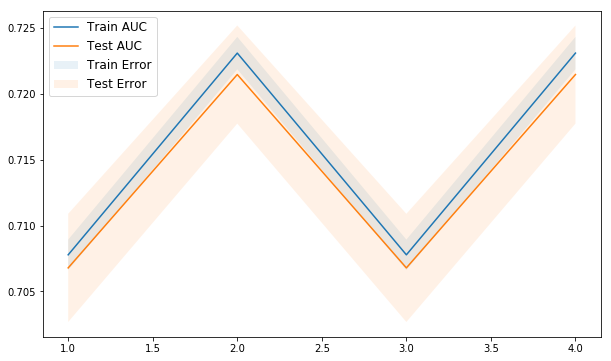

In [39]:
# get results
train_auc_mean = np.array(scores['train-AUC-mean'])
train_auc_std = np.array(scores['train-AUC-std'])
test_auc_mean = np.array(scores['test-AUC-mean'])
test_auc_std = np.array(scores['test-AUC-std'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(train_auc_mean)+1), train_auc_mean, label='Train AUC')
ax.plot(range(1, len(test_auc_mean)+1), test_auc_mean, label='Test AUC')
ax.fill_between(range(1, len(train_auc_mean)+1), train_auc_mean+train_auc_std, 
                train_auc_mean-train_auc_std, alpha=0.1, label='Train Error')
ax.fill_between(range(1, len(test_auc_mean)+1), test_auc_mean+test_auc_std, 
                test_auc_mean-test_auc_std, alpha=0.1, label='Test Error')
ax.legend(fontsize=12)
plt.show()

# CatBoost Random Search

In [28]:
learning_rate_list = []
bootstrap_type_list = []
depth_list = []

# CatBoost Boosting

In [14]:
# build CatBoost classifier
model = CatBoostClassifier(loss_function='Logloss', custom_metric='AUC', eval_metric='AUC',
                           iterations=1000, learning_rate=None, random_seed=42, l2_leaf_reg=None,
                           bootstrap_type=None, bagging_temperature=None, subsample=None,
                           random_strength=None, use_best_model=None, depth=6, ignored_features=None,
                           one_hot_max_size=None, has_time=False, rsm=None, nan_mode=None,
                           leaf_estimation_iterations=None, leaf_estimation_method=None,
                           fold_len_multiplier=None, approx_on_full_history=None, class_weights=[1, 11],
                           boosting_type=None, allow_const_label=None, od_pval=None, od_wait=None,
                           od_type=None, border_count=None, feature_border_type=None, classes_count=None,
                           thread_count=None, used_ram_limit=None, gpu_ram_part=None, name=None, 
                           gpu_cat_features_storage=None, data_partition=None, task_type=None, devices=None,
                           train_dir=None, model_size_reg=None, allow_writing_files=None, save_snapshot=None,  
                           snapshot_file=None, simple_ctr=None, combinations_ctr=None, per_feature_ctr=None, 
                           counter_calc_method=None, max_ctr_complexity=None, ctr_leaf_count_limit=None, 
                           store_all_simple_ctr=None, final_ctr_computation_mode=None)

model.fit(X=train_pool, eval_set=None, verbose=None, logging_level=None, 
          plot=False, column_description=None, verbose_eval=None, 
          metric_period=50, silent=None, early_stopping_rounds=None)

catboost_test_pred = model.predict_proba(data=test_pool)[:, 1]

Learning rate set to 0.084759
0:	total: 2.17s	remaining: 36m 6s
50:	total: 1m 31s	remaining: 28m 27s
100:	total: 2m 59s	remaining: 26m 40s
150:	total: 4m 29s	remaining: 25m 13s
200:	total: 5m 57s	remaining: 23m 42s
250:	total: 7m 28s	remaining: 22m 17s
300:	total: 8m 57s	remaining: 20m 48s
350:	total: 10m 26s	remaining: 19m 19s
400:	total: 11m 57s	remaining: 17m 51s
450:	total: 13m 29s	remaining: 16m 24s
500:	total: 14m 58s	remaining: 14m 54s
550:	total: 16m 27s	remaining: 13m 25s
600:	total: 17m 57s	remaining: 11m 55s
650:	total: 19m 26s	remaining: 10m 25s
700:	total: 20m 56s	remaining: 8m 55s
750:	total: 22m 25s	remaining: 7m 26s
800:	total: 23m 54s	remaining: 5m 56s
850:	total: 25m 24s	remaining: 4m 26s
900:	total: 26m 52s	remaining: 2m 57s
950:	total: 28m 22s	remaining: 1m 27s
999:	total: 29m 48s	remaining: 0us


In [27]:
# make prediction files
test_id = test['SK_ID_CURR'].values
test_pred = catboost_test_pred

catboost_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
                            columns=['SK_ID_CURR', 'TARGET'])
catboost_csv.to_csv('./result/boosting_catboost_balanced.csv', index=False)